In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
import IPython
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Import the Data and make a summary

In [5]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

### 1.1 Get a first look of the data

In [6]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.2 Check the null values and a brief describe

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#### From the first look of data, we notice several things:
#### 1. There are null values for both train and test data on catogory Age and Cabin
#### 2. There are several categorical variables and we may need to do data cleaning and data propressing before fitting the model.
#### 3. There are some catogories which contains crazy inputs like Name and Ticket, we may need to transform them into some valuable information.

In [11]:
Dataset = [train,test]
Dataset
## Concat the dataframe to do the data cleaning

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

## 2. Data Cleaning and Preprocessing

### 2.1 Name
### The Name is so noisy. We notice that every name has a specific title (Mr, Master...), and the title is somehow related to the Age.
### For example, the people in the same title class are likely to have similar age, we proceed with is thought to get the null value of Age.

In [12]:
##Frist we count the number of people in each class
for dataset in Dataset:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [13]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

In [14]:
##We notice some title has only 1 or 2 people, so we just replace them with the majority to make the code easier.
def replace_titles(x):
    title=x['Title']
    if title in ['Countess','Rev','Major','Sir','Lady']:
        return 'Master'
    if title in ['Col','Capt',]:
        return 'Mr'
    elif title in ['Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title in ['Dr','Don','Jonkheer','Dona']:
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)

In [15]:
train['Title'].value_counts()

Mr        520
Miss      185
Mrs       135
Master     51
Name: Title, dtype: int64

<AxesSubplot:xlabel='Title', ylabel='Survived'>

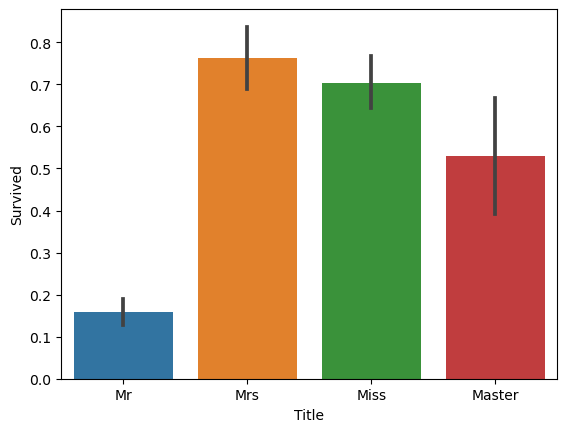

In [16]:
sns.barplot(x='Title',y='Survived',data = train)

In [17]:
## From the bar plot, we can see that Mr class has the lowest survival probability.

In [18]:
## Replace the null value for Age according to the mean value for each class.
train["Age"].fillna(train.groupby("Title")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("mean"), inplace=True)

In [19]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

### 2.2 SibSp and Parch
### Both siblings and parch are a measurement of the aloness.
### We want to see if the survival rate has connectiong to the family mumbers.

In [20]:
for dataset in Dataset:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    del dataset['SibSp']
    del dataset['Parch']

### 2.3 Tickets
### We want to see if there is the situation that several people use one ticket and if this senario affects survival rate.

In [21]:
train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

<AxesSubplot:xlabel='peoplenumber', ylabel='Survived'>

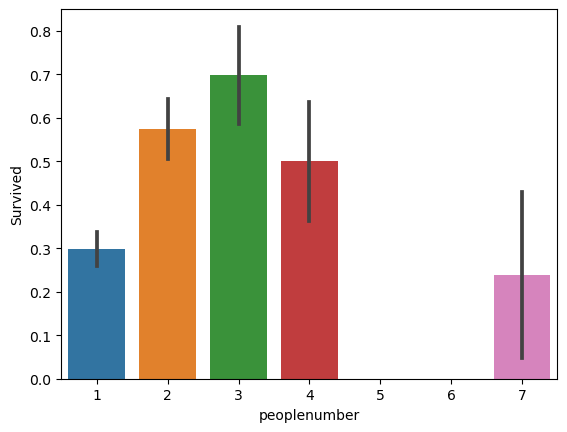

In [22]:
for dataset in Dataset:
    Ticket_Count = dataset['Ticket'].value_counts()
    dataset['peoplenumber'] = dataset['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x = 'peoplenumber', y = "Survived", data = train)

### 2.4 Fare
### I also want to figure out if the fare has relation with the survival rate. In my assumption, maybe high fare will have high survival rate.
### Since the Fare is so messy, I want to use fare range to divide fares into different group for the further analysis.

In [23]:
def fare_range_plot(dataset, train=True):
    if train:
        survived = dataset[dataset['Survived']==1]['Fare']
    else:
        survived = dataset['Fare']
    list_100 = list(range(0, 100, 10))
    list_100_to_700 = list(range(100, 700, 100))
    list_100.extend(list_100_to_700)
    survived_range = pd.cut(survived, list_100, right=True)
    survived_freq = survived_range.value_counts(sort=False)
    all_range = pd.cut(dataset['Fare'], list_100, right=True)
    all_freq = all_range.value_counts(sort=False)
    prob = survived_freq / all_freq
    prob.plot(kind='bar')
    
    return list_100, prob

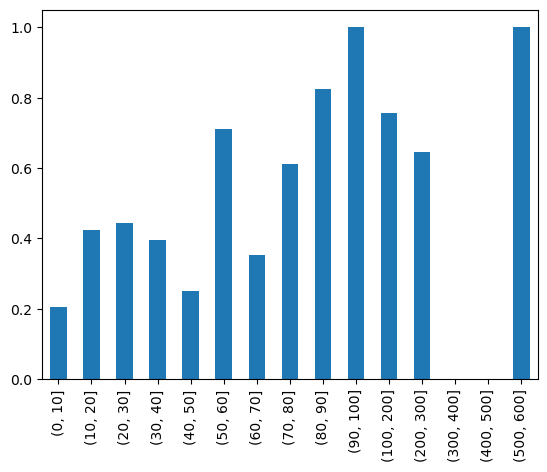

In [24]:
list_cut, prob = fare_range_plot(train)
train['Fare_level'] = pd.cut(x = train['Fare'], bins = list_cut, labels = prob, include_lowest = True, ordered = False)
test['Fare_level'] = pd.cut(x = test['Fare'], bins = list_cut, labels = prob, include_lowest = True, ordered = False)

### 2.5 Cabin
### We notice that different cabins are represented differently and we want to make use of it.

<AxesSubplot:xlabel='RN', ylabel='Survived'>

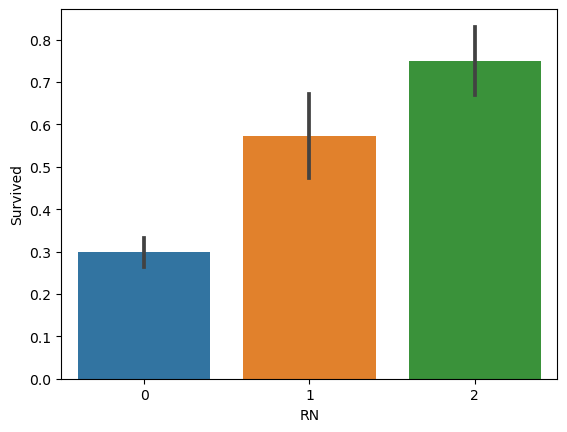

In [25]:
train['Cabin']=train['Cabin'].fillna('Z')
train['RN']=train['Cabin'].apply(lambda x:x[0])
def Cabin_Label(x):
    if ((x=='E')|(x=='D')|(x=='B')):
        return 2
    elif ((x=='C')|(x=='G')|(x=='A')|(x=='F')):
        return 1
    else:
        return 0
train['RN']=train['RN'].apply(Cabin_Label)
sns.barplot(x='RN',y='Survived',data=train)

In [26]:
test['Cabin']=test['Cabin'].fillna('Z')
test['RN']=test['Cabin'].  apply(lambda x:x[0])
def Cabin_Label(x):
    if ((x=='E')|(x=='D')|(x=='B')):
        return 2
    elif ((x=='C')|(x=='G')|(x=='A')|(x=='F')):
        return 1
    else:
        return 0
test['RN']=test['RN'].apply(Cabin_Label)
#sns.barplot(x='RN',y='Survived',data=test)

### Then we need to drop some features and use the new features we created to make the whole dataset easier to be analysed.

In [27]:
features_drop = ['PassengerId','Name','Ticket','Cabin','Embarked','Fare']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
target = train['Survived']
train = train.drop('Survived', axis=1)

### Brand new dataset

In [28]:
train.head(5)

,Pclass,Sex,Age,Title,relatives,peoplenumber,Fare_level,RN
0,3,male,22.0,Mr,1,1,0.205607,0
1,1,female,38.0,Mrs,1,1,0.612903,1
2,3,female,26.0,Miss,0,1,0.205607,0
3,1,female,35.0,Mrs,1,2,0.710526,1
4,3,male,35.0,Mr,0,1,0.205607,0


### Till now we have 
### numerial variables: Age, relatives, peoplenumber,Fare_level
### Categorical variable: Pclass, Sex, Title, RN

## 3. Fit Model

### 3.1 Preprocessing

In [29]:
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

In [30]:
cat_feature = ['Pclass','Sex','Title','RN']
num_feature = ['Age','relatives','peoplenumber','Fare_level']

In [31]:
from sklearn.preprocessing import LabelEncoder
l1=LabelEncoder()
for feature in cat_feature:
    train[feature]=l1.fit_transform(train[feature])
    test[feature]=l1.fit_transform(test[feature])

In [32]:
train.head(5)

,Pclass,Sex,Age,Title,relatives,peoplenumber,Fare_level,RN
0,2,1,22.0,2,1,1,0.205607,0
1,0,0,38.0,3,1,1,0.612903,1
2,2,0,26.0,1,0,1,0.205607,0
3,0,0,35.0,3,1,2,0.710526,1
4,2,1,35.0,2,0,1,0.205607,0


In [41]:
target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

### 3.2 Model

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [42]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.01 ,n_estimators=860,max_depth=3,subsample=1, colsample_bytree=1, gamma=6,reg_alpha = 14,reg_lambda = 3)
scoring = 'accuracy'
score = cross_val_score(xgb, train, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
round(np.mean(score)*100,2)

[nan nan nan nan nan nan nan nan nan nan]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 1397, in fit
    enable_categorical=self.enable_categorical,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 41

nan